In [1]:
import pandas as pd
from sklearn import preprocessing
from soyviz import plot_los_tres
from combat.pycombat import pycombat
import matplotlib.pyplot as plt

In [2]:
venancio = pd.read_parquet('../expresion/venancio.parquet')
venancio

Gene,Glyma.01G000100,Glyma.01G000137,Glyma.01G000174,Glyma.01G000211,Glyma.01G000248,Glyma.01G000285,Glyma.01G000322,Glyma.01G000359,Glyma.01G000400,Glyma.01G000600,...,Glyma.U044501,Glyma.U044700,Glyma.U044800,Glyma.U045000,Glyma.U045100,Glyma.U045402,Glyma.U045502,Glyma.U045602,Glyma.U045702,Glyma.U045802
biosample,,,,,,,,,,,,,,,,,,,,,
SAMN00265078,5.453108,59.054636,1.408092,1.218809,0.000000,2.651369,2.801494,0.377480,0.523319,2.993846,...,0.0,0.000000,0.0,0.0,0.0,4.317951,0.421438,11.072744,0.000000,0.053070
SAMN00265079,6.500151,56.896441,6.155613,2.903028,14.714201,12.752819,4.904175,6.120868,7.059885,6.651526,...,0.0,0.000000,0.0,0.0,0.0,4.313916,0.000000,8.977273,0.518904,1.336911
SAMN00265080,3.103596,0.000000,4.038168,0.000000,2.434158,7.362351,1.693301,4.158352,9.958392,9.768484,...,0.0,0.000000,0.0,0.0,0.0,0.723192,0.000000,6.653363,0.000000,2.470588
SAMN00265081,4.226230,0.000000,4.021155,0.441538,2.820968,4.016449,1.627095,4.222031,7.327622,10.667464,...,0.0,0.000000,0.0,0.0,0.0,0.931953,0.297342,0.000000,0.390688,0.777894
SAMN00265082,2.582089,0.000000,1.710374,0.980639,5.646594,3.689870,1.837848,8.406095,5.689184,4.331051,...,0.0,0.000000,0.0,0.0,0.0,0.495017,0.000000,2.276112,0.000000,0.595369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN09295126,6.011819,0.000000,2.234152,0.000000,0.000000,2.596353,1.998173,0.000000,9.105045,4.742704,...,0.0,0.000000,0.0,0.0,0.0,8.817960,0.000000,32.194774,0.000000,0.000000
SAMN09295127,5.552961,21.092150,0.000000,0.000000,0.000000,0.000000,0.700031,1.792143,8.356985,3.354179,...,0.0,0.000000,0.0,0.0,0.0,5.273037,0.000000,0.000000,0.000000,0.604034
SAMN09295128,5.692426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.120328,4.756147,3.019845,...,0.0,0.000000,0.0,0.0,0.0,1.545678,0.000000,0.000000,0.000000,0.000000


In [3]:
annot = pd.read_csv('../anotacion/gemini_annot.csv', index_col=0)
annot = annot[annot.isna().sum(axis=1) == 0]
annot

,bioproject,tejido,estres,tratamiento
biosample,,,,
SAMD00235524,PRJDB10183,seedling,fungus,control
SAMD00235525,PRJDB10183,seedling,fungus,control
SAMD00235526,PRJDB10183,seedling,fungus,control
SAMD00235527,PRJDB10183,seedling,fungus,control
SAMD00235528,PRJDB10183,seedling,fungus,control
...,...,...,...,...
SAMN36760719,PRJNA999924,seed,cold,treatment
SAMN36760720,PRJNA999924,seed,cold,treatment
SAMN36760721,PRJNA999924,seed,cold,treatment


In [4]:
venancio, annot = venancio.align(annot, join='inner', axis=0)
venancio

Gene,Glyma.01G000100,Glyma.01G000137,Glyma.01G000174,Glyma.01G000211,Glyma.01G000248,Glyma.01G000285,Glyma.01G000322,Glyma.01G000359,Glyma.01G000400,Glyma.01G000600,...,Glyma.U044501,Glyma.U044700,Glyma.U044800,Glyma.U045000,Glyma.U045100,Glyma.U045402,Glyma.U045502,Glyma.U045602,Glyma.U045702,Glyma.U045802
biosample,,,,,,,,,,,,,,,,,,,,,
SAMN03274465,0.957969,0.000000,0.926390,0.000000,1.954501,3.940956,0.533728,2.731799,5.332279,1.669487,...,0.00000,0.000000,0.0,0.0,0.0,2.613025,0.0,32.053110,0.0,1.787164
SAMN03274466,2.461144,68.598711,0.000000,0.000000,1.673139,0.562285,0.445474,1.559062,2.649226,1.475461,...,0.11857,0.000000,0.0,0.0,0.0,2.236914,0.0,54.878968,0.0,1.388446
SAMN03274467,2.430842,16.948481,0.293822,5.358182,2.480265,0.697194,0.702120,1.155578,3.850957,1.086780,...,0.00000,0.000000,0.0,0.0,0.0,3.316007,0.0,40.676353,0.0,1.950443
SAMN03274468,1.885762,0.000000,0.547198,1.931943,0.000000,0.000000,0.000000,1.075741,1.854763,0.955539,...,0.00000,0.000000,0.0,0.0,0.0,2.057940,0.0,0.000000,0.0,0.971542
SAMN03274469,2.519760,46.848863,0.406204,2.868298,3.428172,0.000000,0.969096,0.798560,6.533728,2.011225,...,0.00000,0.000000,0.0,0.0,0.0,1.527680,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN09295126,6.011819,0.000000,2.234152,0.000000,0.000000,2.596353,1.998173,0.000000,9.105045,4.742704,...,0.00000,0.000000,0.0,0.0,0.0,8.817960,0.0,32.194774,0.0,0.000000
SAMN09295127,5.552961,21.092150,0.000000,0.000000,0.000000,0.000000,0.700031,1.792143,8.356985,3.354179,...,0.00000,0.000000,0.0,0.0,0.0,5.273037,0.0,0.000000,0.0,0.604034
SAMN09295128,5.692426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.120328,4.756147,3.019845,...,0.00000,0.000000,0.0,0.0,0.0,1.545678,0.0,0.000000,0.0,0.000000


Text(0.5, 0.98, 'Expresión cruda')

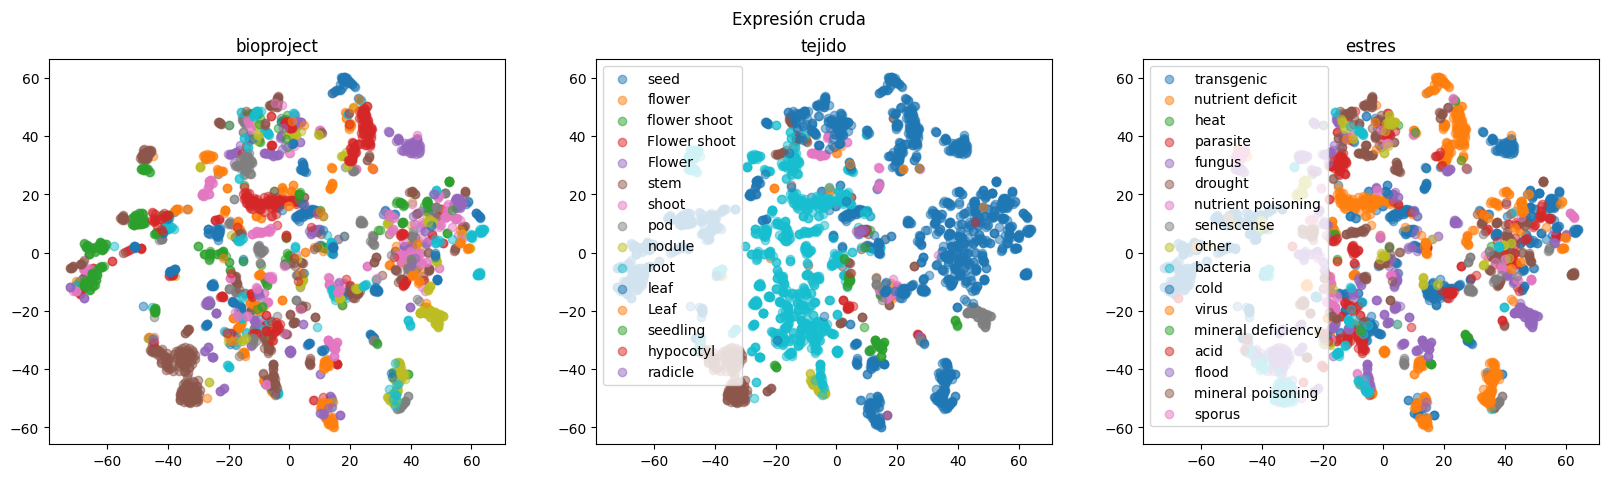

In [5]:
plot_los_tres(venancio, annot)
plt.suptitle('Expresión cruda')

## Filtro observaciones y features

Varianza 0

In [6]:
annot['tejido'].value_counts()

tejido
leaf            1066
root             852
seed             536
stem             258
pod               79
seedling          58
shoot             57
nodule            36
hypocotyl         24
flower            20
Flower shoot       8
radicle            7
Leaf               5
flower shoot       3
Flower             2
Name: count, dtype: int64

In [7]:
annot['estres'].value_counts()

estres
transgenic            724
fungus                515
nutrient deficit      448
drought               282
parasite              271
virus                 192
bacteria              171
nutrient poisoning    108
other                  90
senescense             51
mineral poisoning      49
cold                   38
heat                   37
acid                   21
mineral deficiency      7
sporus                  6
flood                   1
Name: count, dtype: int64

In [8]:
consamples = annot['bioproject'].map(annot['bioproject'].value_counts() > 2)
conestres = annot['estres'].map(annot['estres'].value_counts() > 10)
convarianza = venancio.var() > 0.01

filtrado = venancio.loc[consamples & conestres, convarianza]

filtrado

Gene,Glyma.01G000100,Glyma.01G000137,Glyma.01G000174,Glyma.01G000211,Glyma.01G000248,Glyma.01G000285,Glyma.01G000322,Glyma.01G000359,Glyma.01G000400,Glyma.01G000600,...,Glyma.U044501,Glyma.U044700,Glyma.U044800,Glyma.U045000,Glyma.U045100,Glyma.U045402,Glyma.U045502,Glyma.U045602,Glyma.U045702,Glyma.U045802
biosample,,,,,,,,,,,,,,,,,,,,,
SAMN03274465,0.957969,0.000000,0.926390,0.000000,1.954501,3.940956,0.533728,2.731799,5.332279,1.669487,...,0.00000,0.000000,0.0,0.0,0.0,2.613025,0.0,32.053110,0.0,1.787164
SAMN03274466,2.461144,68.598711,0.000000,0.000000,1.673139,0.562285,0.445474,1.559062,2.649226,1.475461,...,0.11857,0.000000,0.0,0.0,0.0,2.236914,0.0,54.878968,0.0,1.388446
SAMN03274467,2.430842,16.948481,0.293822,5.358182,2.480265,0.697194,0.702120,1.155578,3.850957,1.086780,...,0.00000,0.000000,0.0,0.0,0.0,3.316007,0.0,40.676353,0.0,1.950443
SAMN03274468,1.885762,0.000000,0.547198,1.931943,0.000000,0.000000,0.000000,1.075741,1.854763,0.955539,...,0.00000,0.000000,0.0,0.0,0.0,2.057940,0.0,0.000000,0.0,0.971542
SAMN03274469,2.519760,46.848863,0.406204,2.868298,3.428172,0.000000,0.969096,0.798560,6.533728,2.011225,...,0.00000,0.000000,0.0,0.0,0.0,1.527680,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN09295126,6.011819,0.000000,2.234152,0.000000,0.000000,2.596353,1.998173,0.000000,9.105045,4.742704,...,0.00000,0.000000,0.0,0.0,0.0,8.817960,0.0,32.194774,0.0,0.000000
SAMN09295127,5.552961,21.092150,0.000000,0.000000,0.000000,0.000000,0.700031,1.792143,8.356985,3.354179,...,0.00000,0.000000,0.0,0.0,0.0,5.273037,0.0,0.000000,0.0,0.604034
SAMN09295128,5.692426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.120328,4.756147,3.019845,...,0.00000,0.000000,0.0,0.0,0.0,1.545678,0.0,0.000000,0.0,0.000000


In [9]:
filtrado, annot = filtrado.align(annot, join='inner', axis=0)

Text(0.5, 0.98, 'Expresión cruda')

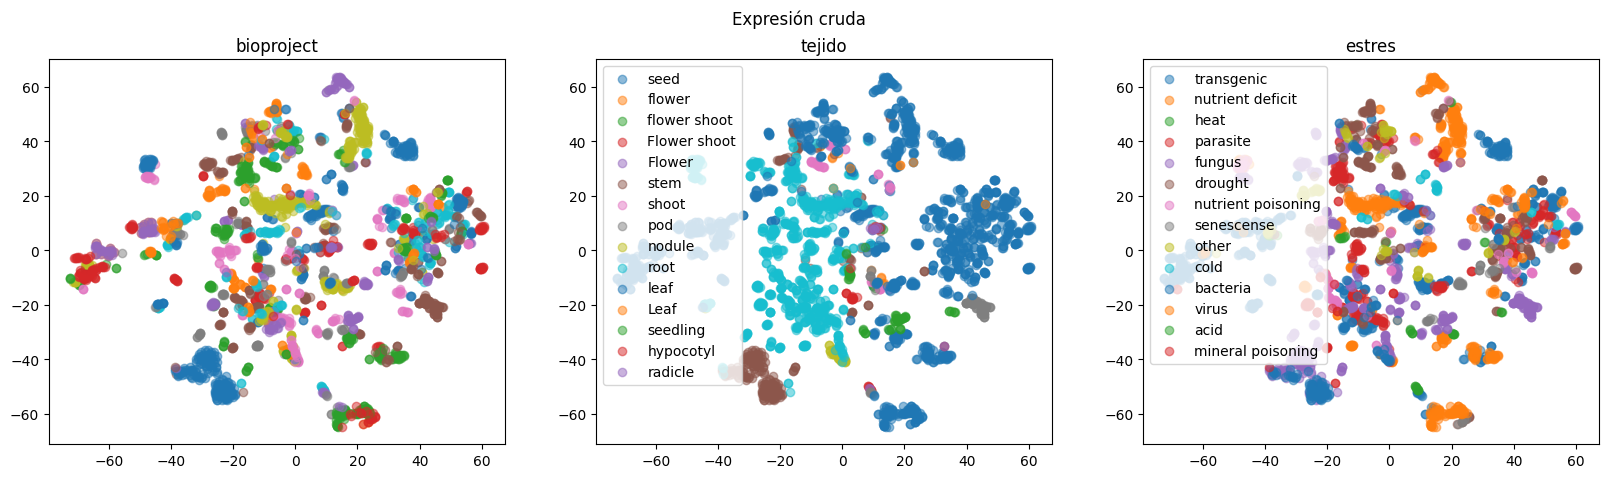

In [10]:
plot_los_tres(filtrado, annot)
plt.suptitle('Expresión cruda')

## Batch correction

In [11]:
combat = pycombat(filtrado.T, annot['bioproject']).T
combat

Found 178 batches.

One batch has only one sample, try setting mean_only=True.

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


/home/godo/.local/lib/python3.10/site-packages/combat/pycombat.py:91: RuntimeWarning: invalid value encountered in scalar divide
  return (2*s2+m*m)/s2
/home/godo/.local/lib/python3.10/site-packages/combat/pycombat.py:93: RuntimeWarning: invalid value encountered in scalar divide
  return (m*s2+m*m*m)/s2
/home/godo/.local/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Finding parametric adjustments.
Adjusting the Data


Gene,Glyma.01G000100,Glyma.01G000137,Glyma.01G000174,Glyma.01G000211,Glyma.01G000248,Glyma.01G000285,Glyma.01G000322,Glyma.01G000359,Glyma.01G000400,Glyma.01G000600,...,Glyma.U044501,Glyma.U044700,Glyma.U044800,Glyma.U045000,Glyma.U045100,Glyma.U045402,Glyma.U045502,Glyma.U045602,Glyma.U045702,Glyma.U045802
biosample,,,,,,,,,,,,,,,,,,,,,
SAMN03274465,3.260031,13.780284,4.501841,1.719787,6.437535,18.090227,1.857200,4.490306,5.620636,4.357987,...,0.080115,0.116953,0.441053,0.066975,0.017168,1.315194,0.002751,11.718556,0.028597,0.829763
SAMN03274466,6.975081,63.252793,3.352424,1.719787,6.135303,6.044669,1.718204,3.069319,3.619154,4.032002,...,0.209534,0.116953,0.441053,0.066975,0.017168,1.199808,0.002751,19.557883,0.028597,0.665814
SAMN03274467,6.900190,26.003311,3.716983,8.781916,7.002296,6.525643,2.122410,2.580423,4.515611,3.378975,...,0.080115,0.116953,0.441053,0.066975,0.017168,1.530859,0.002751,14.680128,0.028597,0.896902
SAMN03274468,5.553042,13.780284,4.031359,4.266104,4.338061,4.040023,1.016602,2.483686,3.026507,3.158475,...,0.080115,0.116953,0.441053,0.066975,0.017168,1.144901,0.002751,0.710216,0.028597,0.494388
SAMN03274469,7.119949,47.567082,3.856421,5.500228,8.020513,4.040023,2.542885,2.147830,6.516883,4.932144,...,0.080115,0.116953,0.441053,0.066975,0.017168,0.982225,0.002751,0.710216,0.028597,0.094900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN09295126,8.343074,10.089710,5.055576,3.654648,3.295732,6.697416,2.619354,2.363627,7.387483,4.312216,...,0.080022,-0.001787,0.391284,-0.018152,0.015299,3.211108,0.020582,30.388907,0.053380,0.050849
SAMN09295127,7.768488,40.356916,1.111243,3.654648,3.295732,3.309149,1.183830,3.971623,6.903698,3.568721,...,0.080022,-0.001787,0.391284,-0.018152,0.015299,2.138524,0.020582,0.038962,0.053380,0.709630
SAMN09295128,7.943127,10.089710,1.111243,3.654648,3.295732,3.309149,0.409715,14.135807,4.574966,3.389700,...,0.080022,-0.001787,0.391284,-0.018152,0.015299,1.010740,0.020582,0.038962,0.053380,0.050849


In [12]:
estandar = filtrado.groupby(annot['bioproject']).apply(lambda g: pd.DataFrame(preprocessing.scale(g), index=g.index, columns=g.columns)).droplevel('bioproject')
# estandar = estandar.groupby(condicion['tejido']).apply(lambda g: pd.DataFrame(preprocessing.scale(g), index=g.index, columns=g.columns)).droplevel('tejido')
estandar

Gene,Glyma.01G000100,Glyma.01G000137,Glyma.01G000174,Glyma.01G000211,Glyma.01G000248,Glyma.01G000285,Glyma.01G000322,Glyma.01G000359,Glyma.01G000400,Glyma.01G000600,...,Glyma.U044501,Glyma.U044700,Glyma.U044800,Glyma.U045000,Glyma.U045100,Glyma.U045402,Glyma.U045502,Glyma.U045602,Glyma.U045702,Glyma.U045802
biosample,,,,,,,,,,,,,,,,,,,,,
SAMD00235524,-1.072615,0.808416,-0.585340,0.810096,0.212778,-0.408748,2.245851,1.957480,2.557878,-0.399676,...,0.000000,0.319354,4.795832,-0.208514,0.0,2.049308,3.313097,2.043983,2.801222,2.774715
SAMD00235525,0.533110,-1.448087,-0.895935,-0.132663,-1.982816,-0.227377,0.611822,-0.540710,0.971716,0.586143,...,0.000000,1.873532,-0.208514,-0.208514,0.0,-0.338822,-0.453769,-0.057080,-0.112920,-0.252802
SAMD00235526,-0.954271,-0.178745,-0.120920,-0.665204,-0.242634,-0.599098,-0.897453,-0.186256,0.560601,0.641570,...,0.000000,0.901554,-0.208514,-0.208514,0.0,0.213771,0.046256,-0.300454,-0.127392,-0.280713
SAMD00235527,-0.530978,0.745086,0.282141,1.166069,-0.122640,-1.180056,-0.887756,2.180590,0.511330,1.376234,...,0.000000,1.171699,-0.208514,4.795832,0.0,-0.482832,-0.453769,-0.475277,-0.829960,-0.477951
SAMD00235528,1.019957,-0.429907,-1.231993,0.267114,-0.787735,-1.158673,-0.659205,0.697304,0.261609,2.368823,...,0.000000,-0.320927,-0.208514,-0.208514,0.0,-0.684275,-0.453769,-0.298520,-0.829960,-0.217395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN28054339,0.506075,-0.447214,-1.565464,-1.465199,-1.041001,0.460932,1.075111,1.607683,-1.289462,-0.194854,...,-0.447214,-0.447214,0.000000,-0.447214,0.0,-0.789456,1.114770,0.843861,0.508791,0.543802
SAMN28054340,1.427110,-0.447214,0.183743,-0.092931,1.000465,1.078987,1.224553,-1.462092,1.136201,0.833547,...,-0.447214,-0.447214,0.000000,2.236068,0.0,1.928671,1.080675,0.460270,-0.937488,1.167019
SAMN28054341,-1.419559,-0.447214,0.301465,-0.504776,-0.207709,0.131549,-1.300609,-0.531610,0.415999,-0.525987,...,-0.447214,-0.447214,0.000000,-0.447214,0.0,-0.323763,-0.994622,-0.339989,1.626717,-1.437173


In [13]:
annot = annot.drop(combat[combat.isna().sum(axis=1) > 0].index)
estandar = estandar.drop(combat[combat.isna().sum(axis=1) > 0].index)
combat = combat.drop(combat[combat.isna().sum(axis=1) > 0].index)

annot

,bioproject,tejido,estres,tratamiento
biosample,,,,
SAMN03274465,PRJNA271477,seed,transgenic,treatment
SAMN03274466,PRJNA271477,seed,transgenic,treatment
SAMN03274467,PRJNA271477,seed,transgenic,treatment
SAMN03274468,PRJNA271477,seed,transgenic,treatment
SAMN03274469,PRJNA271477,seed,transgenic,treatment
...,...,...,...,...
SAMN09295126,PRJNA474234,seedling,fungus,control
SAMN09295127,PRJNA474234,seedling,fungus,control
SAMN09295128,PRJNA474234,seedling,fungus,treatment


Text(0.5, 0.98, 'Expresión estandarizada')

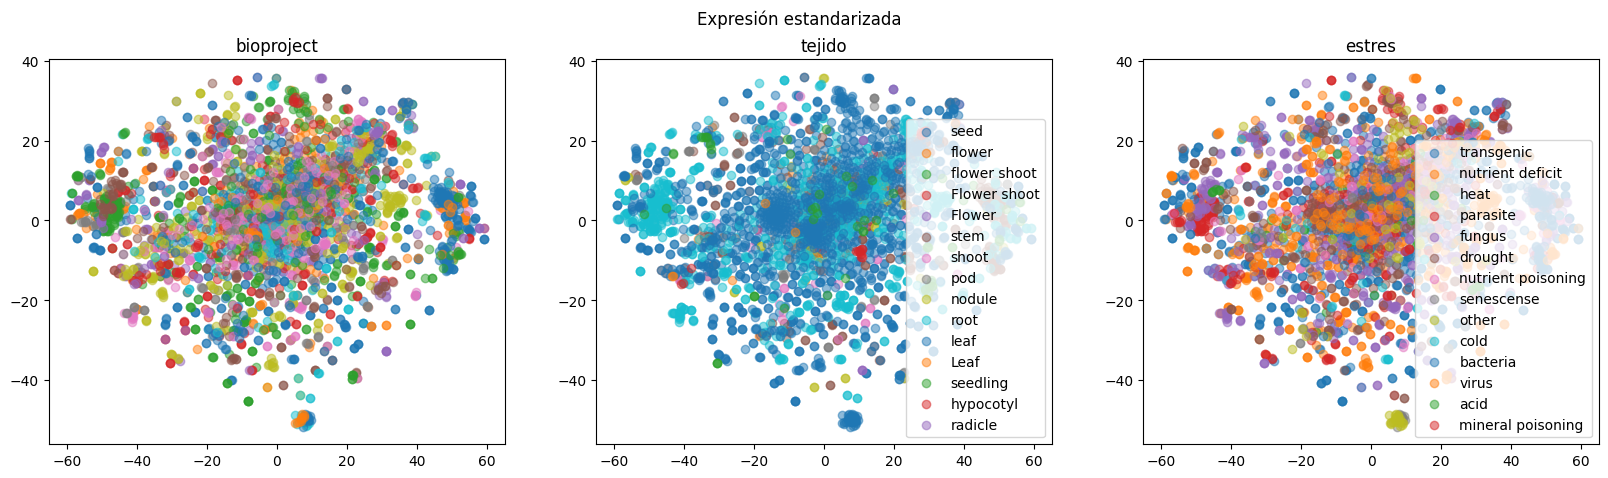

In [14]:
plot_los_tres(estandar, annot)
plt.suptitle('Expresión estandarizada')

Text(0.5, 0.98, 'Expresión ComBat-seq')

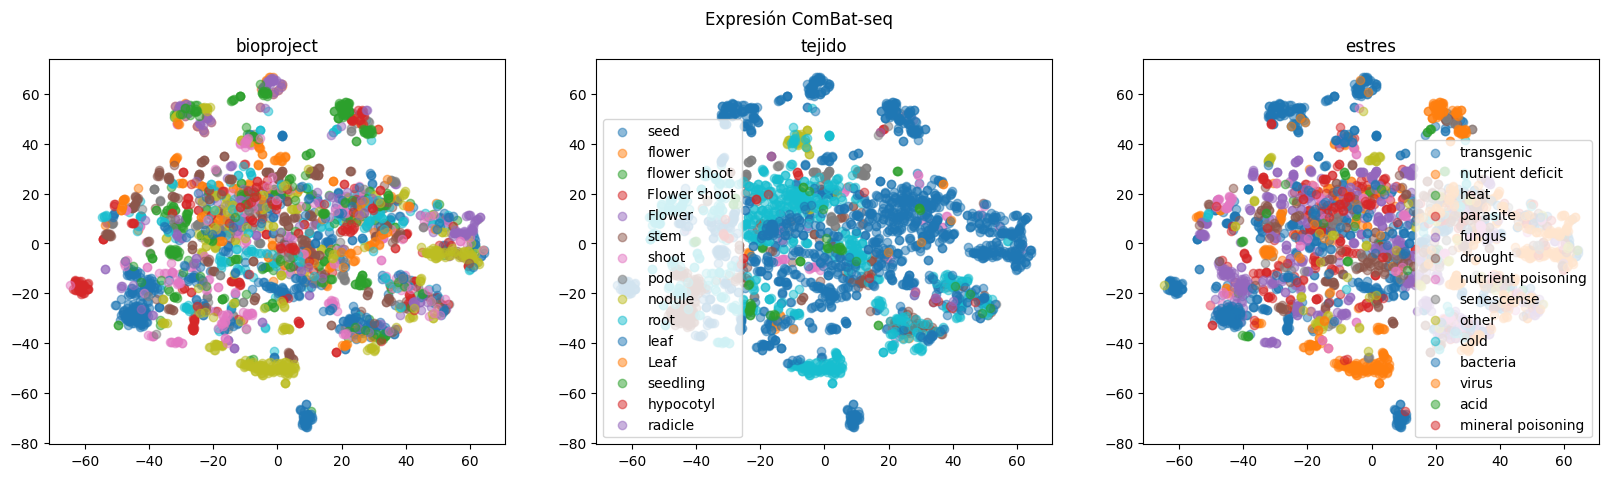

In [15]:
plot_los_tres(combat, annot)
plt.suptitle('Expresión ComBat-seq')

In [16]:
combat.to_parquet('combat.parquet')
estandar.to_parquet('estandar.parquet')
annot.to_parquet('condicion.parquet')